In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances

%matplotlib inline

In [2]:
def set_zoom(ax, ref_layer, buffer = 0):
    '''Sets the zoom of a map to the extent of the reference layer.
    ax is a matplotlib axis used for plotting a map, ref_layer is a geodataframe, buffer is an additional margin around 
    the extent of the reference layer (in units of the CRS of the reference layer).'''
    minx, miny, maxx, maxy = ref_layer.total_bounds
    minx -= buffer
    maxx += buffer
    miny -= buffer
    maxy += buffer
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

In [3]:
# read in data
with open('../90 Data/compiled secondary data/msoas', 'rb') as infile:
    msoas = pickle.load(infile)
with open('../90 Data/compiled secondary data/londonrail', 'rb') as infile:
    londonrail = pickle.load(infile)
with open('../90 Data/compiled secondary data/londontube', 'rb') as infile:
    londontube = pickle.load(infile)
with open('../90 Data/compiled secondary data/imd_msoa', 'rb') as infile:
    imd_msoa = pickle.load(infile)
with open('../90 Data/compiled secondary data/jpr_ampeak_baseline', 'rb') as infile:
    jpr_ampeak_baseline = pickle.load(infile)
with open('../90 Data/compiled secondary data/jpr_sectoral_ampeak_baseline', 'rb') as infile:
    jpr_sectoral_ampeak_baseline = pickle.load(infile)
with open('../90 Data/compiled secondary data/traveltimevariability', 'rb') as infile:
    traveltimevariability = pickle.load(infile)
results_coefs = pd.read_csv('../04 Reliability Data Predictive Analysis/results_lwr02_coefs.csv', index_col = 0)

In [4]:
# compile data for clustering
kmeans_data = imd_msoa[['Index of Multiple Deprivation (IMD) Rank']].join(jpr_ampeak_baseline[['Targets within 45min per User']])
kmeans_data = kmeans_data.join(jpr_sectoral_ampeak_baseline['High-End Services'][['PC Allocation From Sector']])
kmeans_data = kmeans_data.join(traveltimevariability[['Range 50PC to 95PC to City', 'Range 50PC to 95PC to Local Centroid']])
kmeans_data = kmeans_data.join(results_coefs[['dist_bus', 'dist_nationalrail', 'dist_tube', 'dist_walking']])

kmeans_data.rename({'Targets within 45min per User': 'Overall Job Provision Ratio',
                    'PC Allocation From Sector': 'Proportion of Job Availability from High-End Services',
                    'Range 50PC to 95PC to Local Centroid': 'RBT for Trip to Local Destination',
                    'Range 50PC to 95PC to City': 'RBT for Trip to City',
                    'dist_bus': 'Bus km Effect on RBT',
                    'dist_nationalrail': 'National Rail km Effect on RBT',
                    'dist_tube': 'Underground km Effect on RBT',
                    'dist_walking': 'Walking km Effect on RBT'}, axis = 1, inplace = True)
kmeans_data_standardised = StandardScaler().fit_transform(kmeans_data)

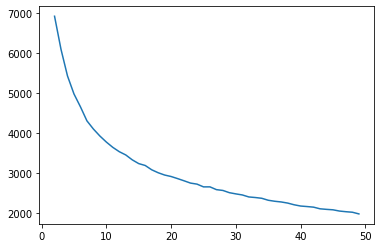

In [5]:
# identify suitable value for k
n_clusters = [i+2 for i in range(48)]
inertias = []
for i in n_clusters:
    inertias.append(KMeans(i, random_state = 1000).fit(kmeans_data_standardised).inertia_)
plt.plot(n_clusters, inertias)

In [6]:
# carry out KMeans clustering
n_clusters = 8
kmeans1 = KMeans(n_clusters, random_state = 6881).fit(kmeans_data_standardised)
# join clustering labels to raw data
kmeans_data['kmeans_cluster_' + str(n_clusters)] = kmeans1.labels_

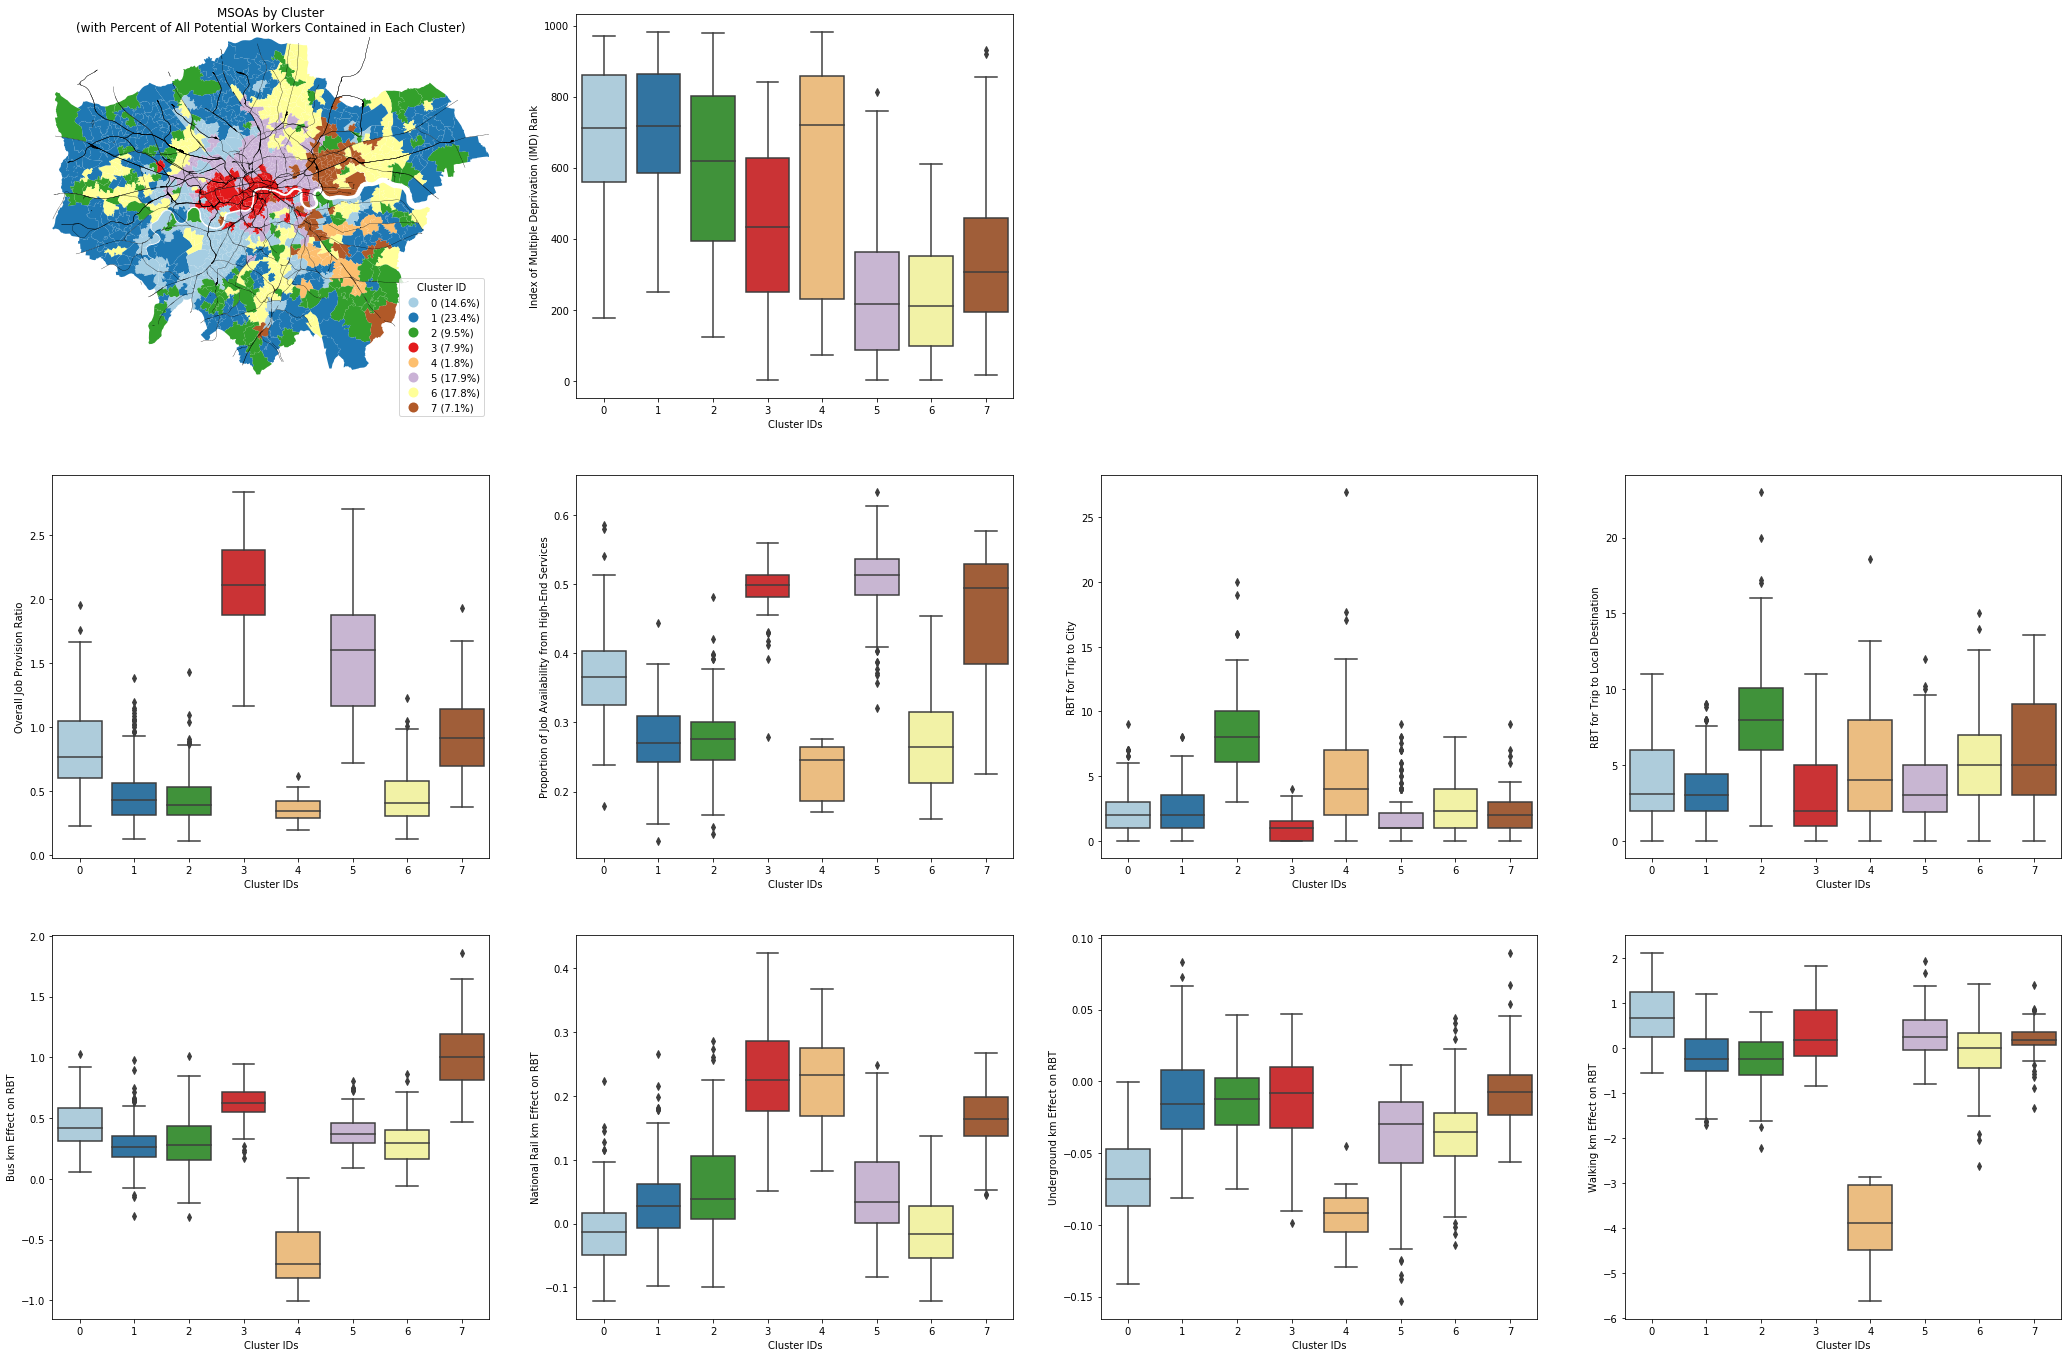

In [24]:
# set colormaps
colormap = []
colors = plt.cm.Paired(np.linspace(0, 1, n_clusters)) # generate colours used in mapping
for c in colors: # convert colours to hex format
    colormap.append(matplotlib.colors.to_hex(c))

# calculate percent working-age pop in each cluster
with open('../90 Data/compiled secondary data/popcounts', 'rb') as infile:
    popcounts = pickle.load(infile)
pop_per_cluster = popcounts[['Pop_WorkingAge']].join(kmeans_data['kmeans_cluster_' + str(n_clusters)])
pop_per_cluster = pop_per_cluster.groupby('kmeans_cluster_' + str(n_clusters)).sum() / popcounts['Pop_WorkingAge'].sum()

# plot data
fig01 = plt.figure(figsize = (36,24))

# clustering map
ax01_01 = fig01.add_subplot(3,4,1)
set_zoom(ax01_01, msoas)
msoas.join(kmeans_data).plot(column = 'kmeans_cluster_' + str(n_clusters), ax = ax01_01, cmap = 'Paired', categorical = True, legend = True)
londontube.plot(color = 'black', linewidth = .3, ax = ax01_01)
londonrail.plot(color = 'black', linewidth = .3, ax = ax01_01)
legend01_01 = ax01_01.get_legend()
legend01_01.set_bbox_to_anchor((1,.3))
legend01_01.set_title('Cluster ID')
for i in range(len(legend01_01.get_texts())):
    legend01_01.get_texts()[i].set_text(str(i) + ' (' + str(round(pop_per_cluster.at[i,'Pop_WorkingAge'] * 100, 1)) + '%)')
plt.title('MSOAs by Cluster\n(with Percent of All Potential Workers Contained in Each Cluster)')
plt.axis('off')

# boxplots
ax01_02 = fig01.add_subplot(3,4,2)
with sns.color_palette(colormap):
    ax01_02 = sns.boxplot(x = 'kmeans_cluster_' + str(n_clusters), y = 'Index of Multiple Deprivation (IMD) Rank', data = kmeans_data)
ax01_02.set_xlabel('Cluster IDs')
ax01_02.set_ylabel('Index of Multiple Deprivation (IMD) Rank')
    
i = 5
for column in kmeans_data.columns[1:-1]:
    ax01 = fig01.add_subplot(3,4,i)
    with sns.color_palette(colormap):
        ax01 = sns.boxplot(x = 'kmeans_cluster_' + str(n_clusters), y = column, data = kmeans_data)
    ax01.set_xlabel('Cluster IDs')
    ax01.set_ylabel(column)
    i += 1

### Analyse Clustering Stability

In [32]:
# identify which MSOA is closest to each cluster's centroid from the previous analysis
dist_to_cluster_centroids = pairwise_distances(kmeans1.cluster_centers_, kmeans_data_standardised)
cluster_centroids_closest_msoa =[]
for i in range(n_clusters):
    cluster_centroids_closest_msoa.append(np.where(dist_to_cluster_centroids[i] == np.amin(dist_to_cluster_centroids[i])))

In [39]:
# carry out kmeans clustering repeatedly and each time see if each MSOA is clustered with the same cluster as the previous analysis
iters = 1000
clustering_match = [0 for i in range(len(kmeans_data_standardised))]
for i in range(iters):
    kmeans_i = KMeans(n_clusters).fit(kmeans_data_standardised)
    for j in range(len(kmeans_data_standardised)):
        # for each MSOA, first lookup which cluster centroid it was clustered with previously
        # then find out the new clustering label of that cluster centroid
        # then see if the current MSOA has the same clustering label as that cluster centroid in the new clustering
        if kmeans_i.labels_[j] == kmeans_i.labels_[cluster_centroids_closest_msoa[kmeans1.labels_[j]]]:
            clustering_match[j] += 1

Proportion of 1000 K-means Clustering Replications where
MSOA Clustering Matches Original K-means Clustering


(503574.18796895276, 561956.6879520521, 155850.7979227482, 200933.60890773044)

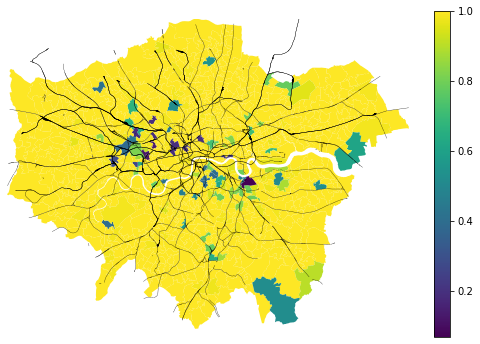

In [47]:
clustering_match_spatial = msoas.copy()
clustering_match_spatial['PC Match'] = clustering_match
clustering_match_spatial['PC Match'] = clustering_match_spatial['PC Match'] / iters

# plot map
fig02 = plt.figure(figsize = (9,6))
ax02_01 = fig02.add_subplot(111)
set_zoom(ax02_01, msoas)
clustering_match_spatial.plot(column = 'PC Match', legend = True, ax = ax02_01)
londontube.plot(color = 'black', linewidth = .3, ax = ax02_01)
londonrail.plot(color = 'black', linewidth = .3, ax = ax02_01)
print('Proportion of ' + str(iters) + ' K-means Clustering Replications where\nMSOA Clustering Matches Original K-means Clustering')
plt.axis('off')